In [123]:
%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
import torch
import torchvision

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.dpi': 300, 'figure.figsize': (9, 6)})

from ggt.data import FITSDataset, get_data_loader
from ggt.models import model_factory, model_stats, save_trained_model
from ggt.utils import discover_devices
from ggt.visualization.spatial_transform import visualize_spatial_transform

## Evaluating GGT

### Setup

Start by configuring the appropriate device.

In [16]:
device = discover_devices()
device

'cuda'

Next, let's define the model and load its weights from disk.

In [30]:
model_path = "../models/ggt-exp-1-balanced-lg-ae65fdee7c284d0da4388455c459e2d6.pt"

In [31]:
cls = model_factory('ggt')
model = cls()
model.load_state_dict(torch.load(model_path))
model = model.to(device)

Now we initialize a `Dataset` and corresponding `DataLoader` to load batches from the test set. We can use a higher batch size to speed up inference.

In [43]:
data_dir = "../data/sdss/"
slug = "balanced-lg"

In [44]:
dataset = FITSDataset(data_dir, slug=slug, normalize=True, split='test')

100%|██████████| 84409/84409 [00:21<00:00, 4008.00it/s]


In [45]:
len(dataset)

84409

In [46]:
loader = get_data_loader(dataset, batch_size=256, n_workers=8, shuffle=False)

### Inference

Here, we'll use the model to generate predictions on the test set batch by batch. The helper method compiles a `DataFrame` of predictions, taking care to use `model.eval()` and `torch.no_grad()`.

In [63]:
def get_predictions(model, loader, device):
    yh = []
    model.eval()
    with torch.no_grad():
        for data in loader:
            X, y = data
            yh.append(model(X.to(device)))
    return pd.DataFrame(torch.cat(yh).cpu().numpy())

In [64]:
%%time
predictions = get_predictions(model, loader, device)
predictions.columns = ['pred']

CPU times: user 4min 29s, sys: 1min 53s, total: 6min 23s
Wall time: 6min 23s


Now, we'll merge the predictions onto the corresponding actuals.

In [65]:
catalog = pd.read_csv(Path(data_dir) / "splits/{}-{}.csv".format(slug, 'test'))
df = pd.concat([catalog.reset_index(drop=True), predictions], axis=1)

In [69]:
df.head()

,ObjID,bt_g,bt_g_err,z,file_name,balance,pred
0,587739302613483644,0.00,0.00,0.0403,587739302613483644-g.fits,"(-0.001, 0.25]",-0.000771
1,587738568703672501,0.03,0.03,0.0640,587738568703672501-g.fits,"(-0.001, 0.25]",0.288596
2,587736543098568960,0.48,0.02,0.0434,587736543098568960-g.fits,"(0.25, 0.5]",0.393759
3,587742549603123205,0.40,0.00,0.0699,587742549603123205-g.fits,"(0.25, 0.5]",0.561891
4,587741709404078330,0.00,0.00,0.0679,587741709404078330-g.fits,"(-0.001, 0.25]",-0.002490


### Evaluation

Let's examine the distribution of errors.

In [74]:
df['err'] = df.bt_g - df.pred

In [75]:
print("Mean absolute error:", df.err.abs().mean())

Mean absolute error: 0.061728249418866704


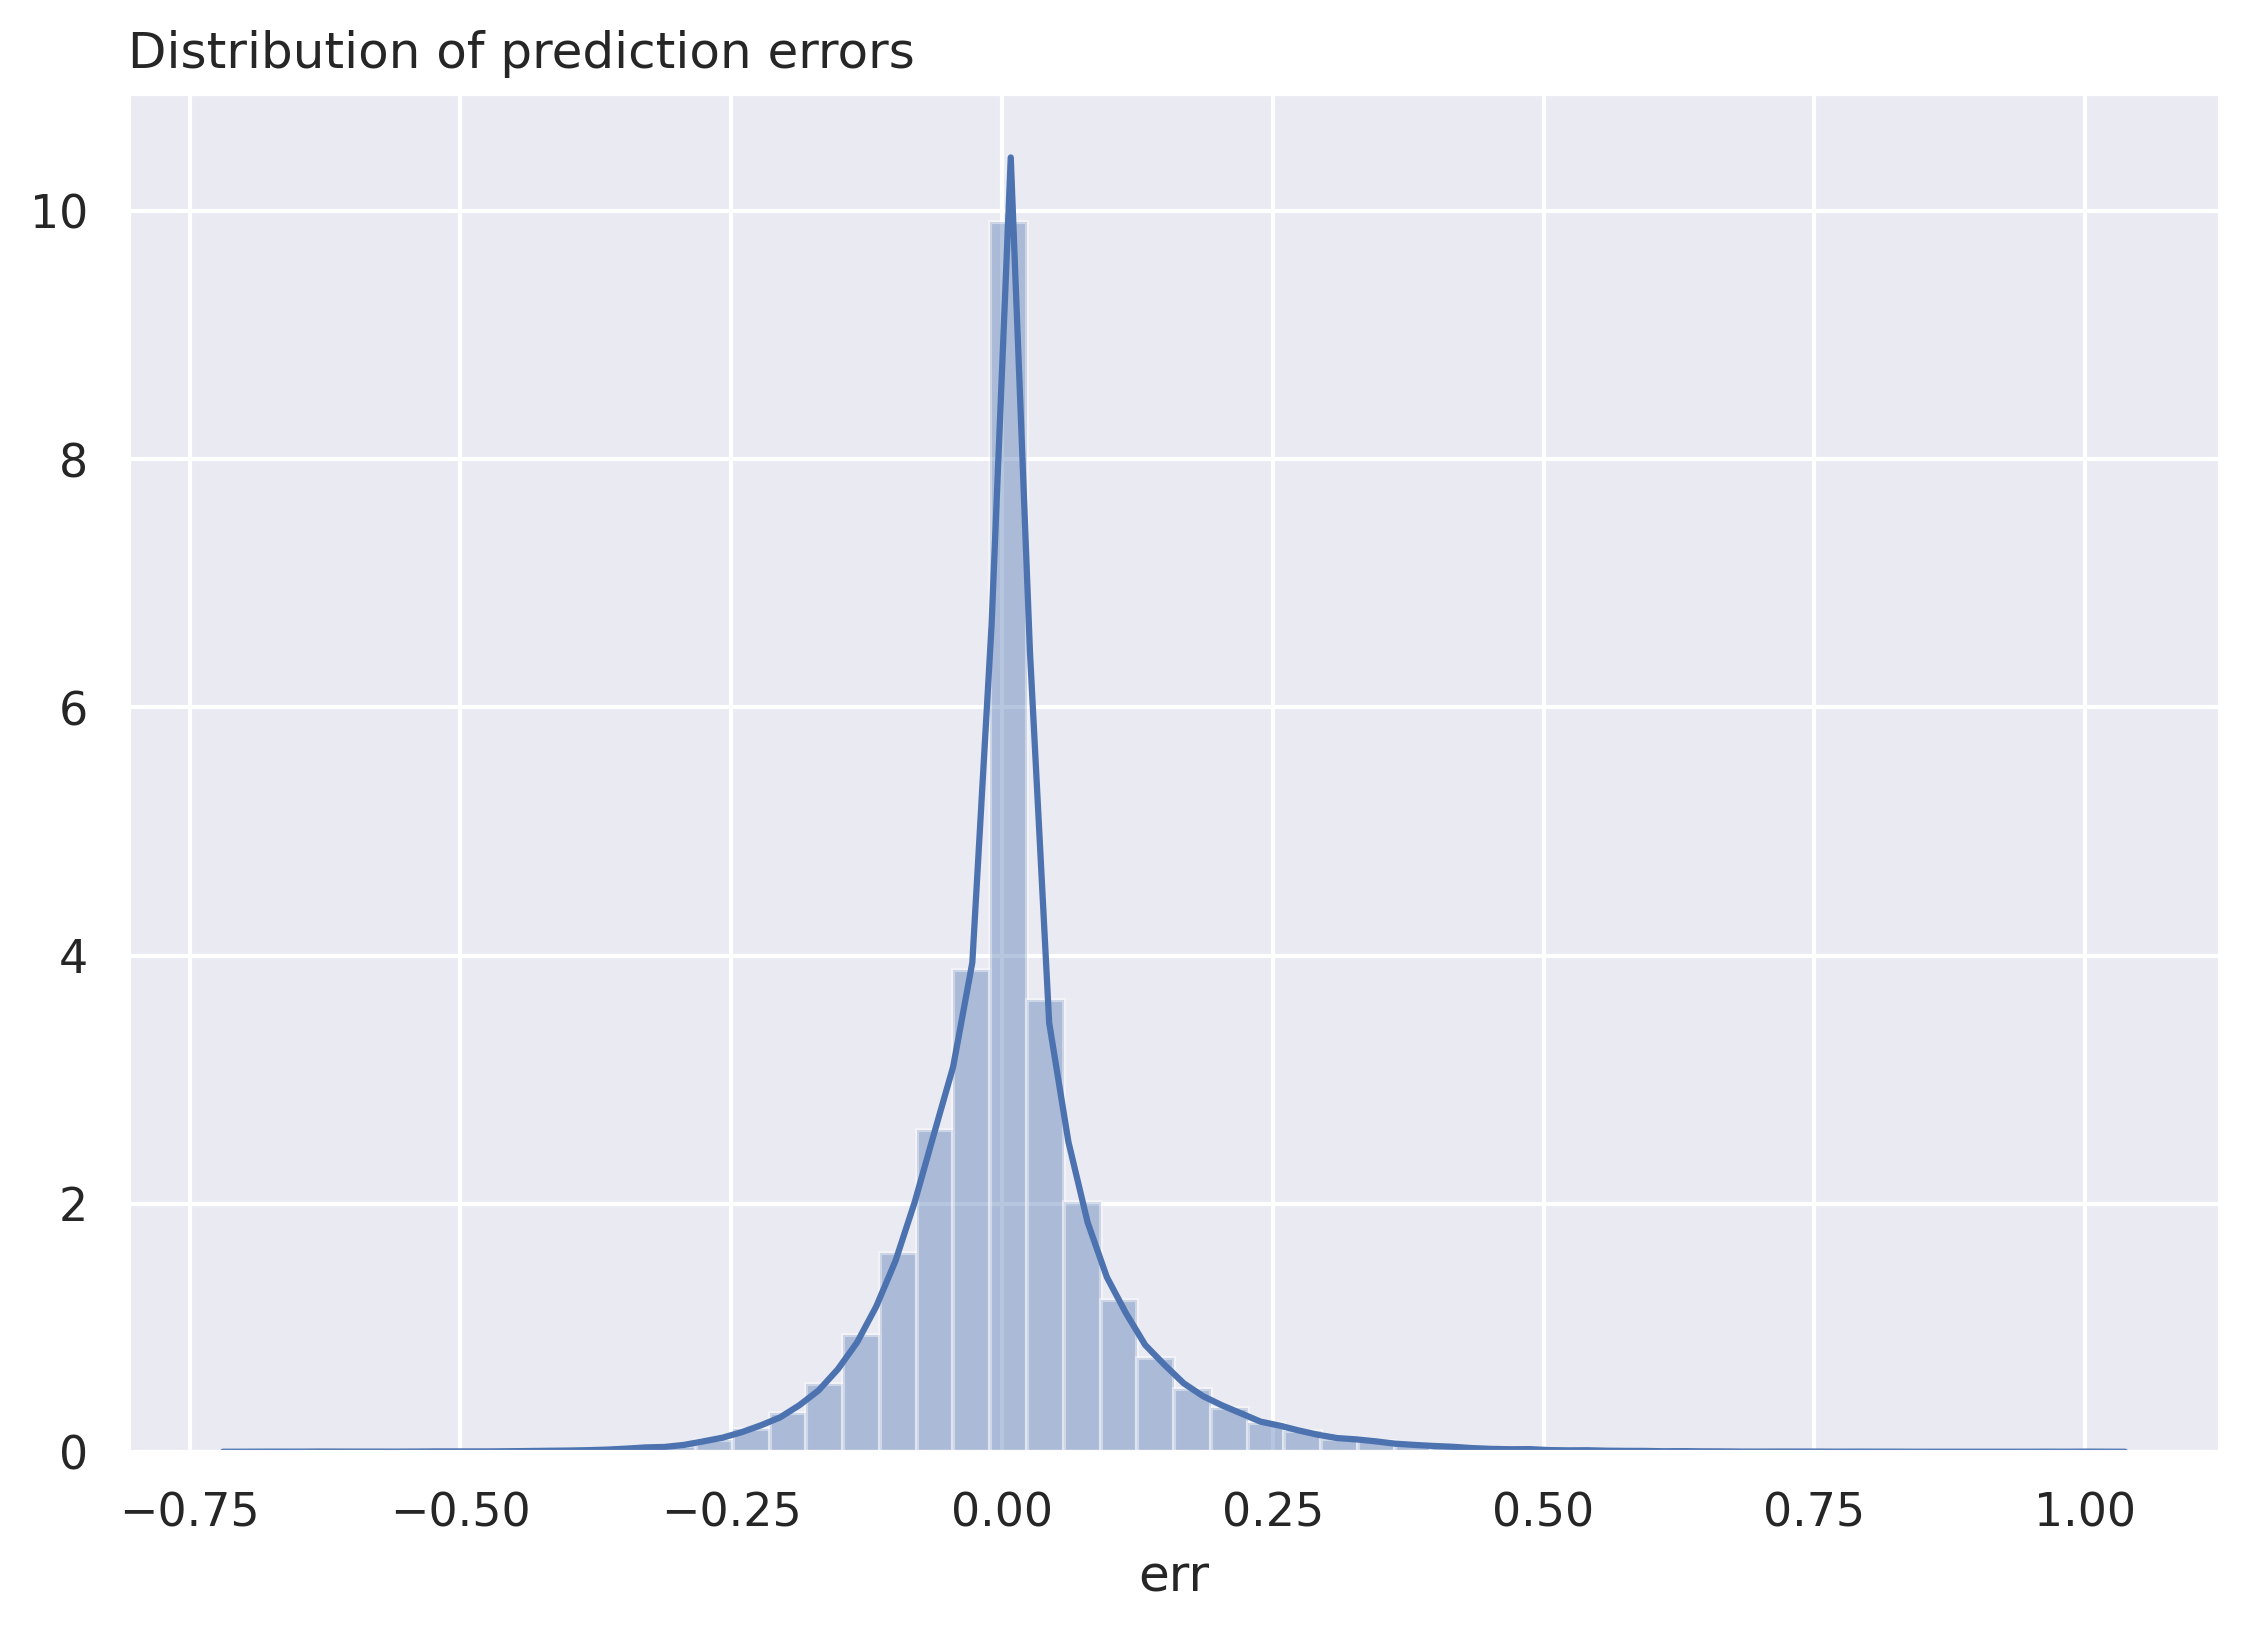

In [130]:
sns.distplot(df.err).set_title('Distribution of prediction errors', loc='left')
plt.show()

How good are we at classification?

In [2]:
# TODO(amritrau) Bin by `df.bt_g`, then compute precision, accuracy, and F1

Do we get certain galaxies "more wrong" or "wrong more" than others?

In [ ]:
# TODO(amritrau) Plot `df.err.abs().mean()` by binned `bt_g` and binned `z`

### Explainability

What is the spatial transformation network doing?

In [ ]:
# TODO(amritrau)